<a href="https://colab.research.google.com/github/DJCordhose/ml-workshop/blob/master/notebooks/classic/strategies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classic Supervised Machine Learning Strategies

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
plt.xkcd()

In [2]:
import sklearn
sklearn.__version__

'0.21.3'

## Loading and exploring our data set

This is a database of customers of an insurance company. Each data point is one customer. The group represents the number of accidents the customer has been involved with in the past

* 0 - red: many accidents
* 1 - green: few or no accidents
* 2 - yellow: in the middle        

In [0]:
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/DJCordhose/ml-workshop/master/notebooks/classic/insurance-customers-1500.csv', sep=';')

In [4]:
df.head()

,speed,age,miles,group
0,98.0,44.0,25.0,1
1,118.0,54.0,24.0,1
2,111.0,26.0,34.0,0
3,97.0,25.0,10.0,2
4,114.0,38.0,22.0,1


In [5]:
df.describe()

,speed,age,miles,group
count,1500.000000,1500.000000,1500.000000,1500.000000
mean,122.492667,44.980667,30.434000,0.998667
std,17.604333,17.130400,15.250815,0.816768
min,68.000000,16.000000,1.000000,0.000000
25%,108.000000,32.000000,18.000000,0.000000
50%,120.000000,42.000000,29.000000,1.000000
75%,137.000000,55.000000,42.000000,2.000000
max,166.000000,100.000000,84.000000,2.000000


In [0]:
y = df['group'].values

In [0]:
X = df.drop('group', axis='columns').values

### We restrict ourselves to two dimensions for now

Because this is all we really can visualize in 2d

In [0]:
# ignore this, it is just technical code to plot decision boundaries
# Adapted from:
# http://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html
# http://jponttuset.cat/xkcd-deep-learning/

from matplotlib.colors import ListedColormap
from matplotlib.ticker import FuncFormatter

import numpy as np

# https://matplotlib.org/users/colormaps.html
# https://matplotlib.org/gallery/images_contours_and_fields/contourf_demo.html#sphx-glr-gallery-images-contours-and-fields-contourf-demo-py
cmap = ListedColormap(['#FF0000', '#0000FF', '#FFFF00'])

font_size=15
title_font_size=25

def meshGrid(x_data, y_data):
    h = 1  # step size in the mesh
    x_min, x_max = 10, 100
    y_min, y_max = 80, 170
#     x_min, x_max = x_data.min() - 1, x_data.max() + 1
#     y_min, y_max = y_data.min() - 1, y_data.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return (xx,yy)
    
def plotPrediction(clf, x_data, y_data, x_label, y_label, ground_truth, title="", 
                   size=(15, 8), n_samples=None, proba=True, prediction=True, 
                   legend=False, # colab has old version of matplotlib, does not support
                   ax=None
                  ):
    xx,yy = meshGrid(x_data, y_data)
    if ax is None:
      fig, ax = plt.subplots(figsize=size)

    if clf:
        Z = clf.predict_proba(np.c_[yy.ravel(), xx.ravel()])

        if proba:
            probaZ = Z.max(axis=1)
            probaZ = probaZ.reshape(xx.shape)
            ax.contourf(xx, yy, probaZ, cmap=plt.cm.binary, alpha=.4)

        if prediction:
            Z = Z.argmax(axis=1)
            Z = Z.reshape(xx.shape)
            ax.contourf(xx, yy, Z, cmap=cmap, alpha=.3)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    
    if n_samples:
      samples = pd.DataFrame(np.array([x_data, y_data, ground_truth]).T).sample(n_samples, random_state=42)
    else:
      samples = pd.DataFrame(np.array([x_data, y_data, ground_truth]).T)
    classes = samples[2]
    scatter = ax.scatter(samples[0], samples[1], c=classes, cmap=cmap, s=50, marker='o', edgecolors='k')

    ax.set_xlabel(x_label, fontsize=font_size)
    ax.set_ylabel(y_label, fontsize=font_size)
    ax.set_title(title, fontsize=title_font_size)

    # https://matplotlib.org/3.1.0/gallery/lines_bars_and_markers/scatter_with_legend.html
    formatter = FuncFormatter(lambda s,t: "Many Accidents" if s == 0 else "No Accidents" if s == 1 else "Few Accidents")
    if legend:
      class_legend = ax.legend(*scatter.legend_elements(alpha=0.6, prop='colors', fmt=formatter), title="Classes")
      ax.add_artist(class_legend)
    
    return ax, scatter


/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


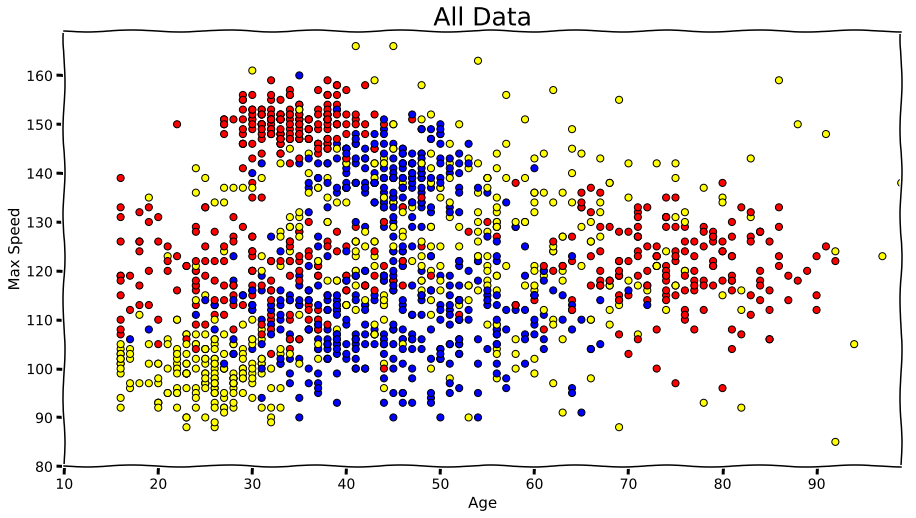

In [52]:
ax, scatter = plotPrediction(None, X[:, 1], X[:, 0], 
               'Age', 'Max Speed', y,
                title="All Data")

## Splitting into test and training data

<img src='https://github.com/djcordhose/ml-workshop/blob/master/img/insurance/generalization.jpg?raw=1'>

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1200, 3), (300, 3), (1200,), (300,))

In [0]:
# train_test_split?

In [12]:
# we have (almost) the same number of samples per categoery 
# in the training...
np.unique(y_train, return_counts=True)

(array([0, 1, 2]), array([401, 400, 399]))

In [13]:
# ... and test dataset
np.unique(y_test, return_counts=True)

(array([0, 1, 2]), array([100, 100, 100]))

In [0]:
# just the first two dimensions
X_train_2_dim = X_train[:, :2]
X_test_2_dim = X_test[:, :2]

(<matplotlib.axes._subplots.AxesSubplot at 0x7f6fc23b3278>,
 <matplotlib.collections.PathCollection at 0x7f6fc2358c50>)

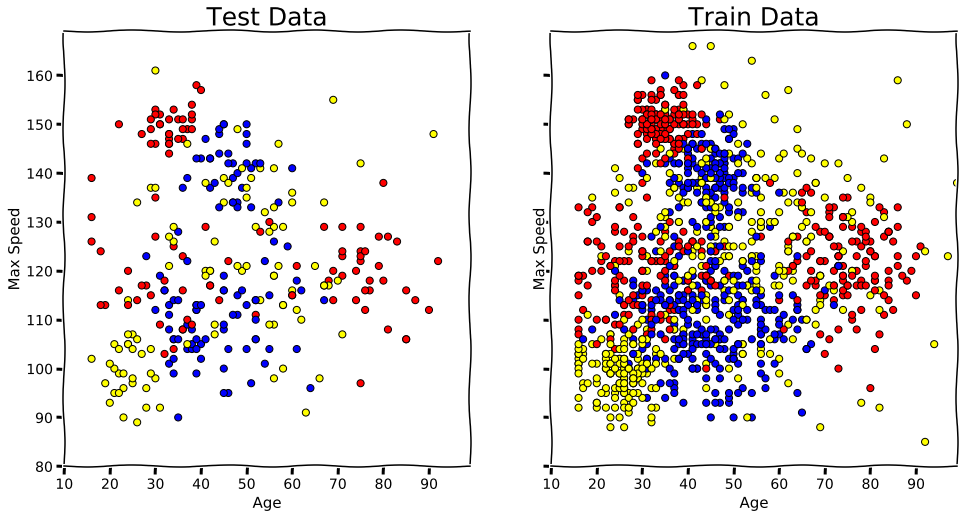

In [53]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(16,8))
la, ra = ax.flatten()
plotPrediction(None, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test, title="Test Data", ax = la)

plotPrediction(None, X_train_2_dim[:, 1], X_train_2_dim[:, 0], 
               'Age', 'Max Speed', y_train, title="Train Data", ax=ra)

# Exercise: Experiment with train/test split

* Execute the notebook up to this point
* change the split ratio between train and test, maybe to 60/40
* change the random seed, why would you want to use it in the first place? is this even a good idea?
* what happens if you do not stratify?


## Overview of most important strategies

https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

https://scikit-learn.org/stable/supervised_learning.html

<img src='https://github.com/djcordhose/ml-workshop/blob/master/notebooks/classic/img/clf_comp.png?raw=1'>

* accuracy is plotted
* decision boundaries are plotted as background
* the darker the color the higher the probability

## Gaussian Naive Bayes: Simple, but effective in cases of blobs

https://en.wikipedia.org/wiki/Naive_Bayes_classifier

* _Bayes_: Bayes’ theorem gives a mean to reverse conditional probabilities
* _Naive_: refers to our assumption that all features are independent to simplify the problem
* _Gaussian_: assumption: each category can be described using a Gaussian distribution

How it works
  * Maximum Likelihood Estimation: assuming we have a Gaussian distribution of independent variables which set of parameters has the highest probability of fitting our dataset (https://en.wikipedia.org/wiki/Maximum_a_posteriori_estimation)
  * practically is done by computing the mean and the standard deviation from our training data (https://machinelearningmastery.com/naive-bayes-for-machine-learning/, https://towardsdatascience.com/maximum-likelihood-estimation-explained-normal-distribution-6207b322e47f) per category


Features  
  * require a small amount of training data to estimate the necessary parameters
  * fast training
  * probability estimation often is poor
  * allows for online learning

https://scikit-learn.org/stable/modules/naive_bayes.html#gaussian-naive-bayes

https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html

In [0]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()

In [18]:
%%time

clf.fit(X_train_2_dim, y_train)

CPU times: user 2.44 ms, sys: 0 ns, total: 2.44 ms
Wall time: 2.69 ms


GaussianNB(priors=None, var_smoothing=1e-09)

In [19]:
# you can set set priors explicitly
# clf = GaussianNB(priors=[0.33, 0.33, 0.34])

# based on number of samples per category
clf.class_prior_

array([0.33416667, 0.33333333, 0.3325    ])

In [20]:
clf.class_count_

array([401., 400., 399.])

In [21]:
# mean per category
clf.theta_

array([[130.55860349,  46.27680798],
       [119.83      ,  44.865     ],
       [117.49874687,  43.26566416]])

In [22]:
clf.sigma_

array([[250.40616694, 449.40716818],
       [257.22610031,  77.24177531],
       [328.10964786, 344.32541284]])

In [23]:
input = [[100.0, 48.0], [150.0, 78.0], [100.0, 18.0]]
# should be [1, 0, 2] = [good, bad, mediocre]
clf.predict(input)

array([1, 0, 2])

(<matplotlib.axes._subplots.AxesSubplot at 0x7f6fc6074588>,
 <matplotlib.collections.PathCollection at 0x7f6fc603cb00>)

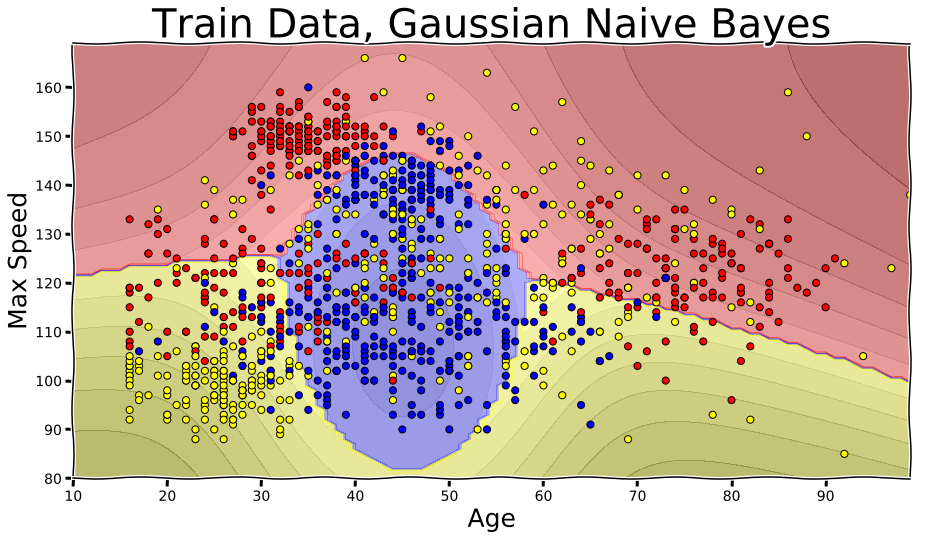

In [24]:
plotPrediction(clf, X_train_2_dim[:, 1], X_train_2_dim[:, 0], 
               'Age', 'Max Speed', y_train,
                title="Train Data, Gaussian Naive Bayes")

In [25]:
clf.score(X_train_2_dim, y_train)

0.6083333333333333

(<matplotlib.axes._subplots.AxesSubplot at 0x7f6fc603cf60>,
 <matplotlib.collections.PathCollection at 0x7f6fc5fc7e48>)

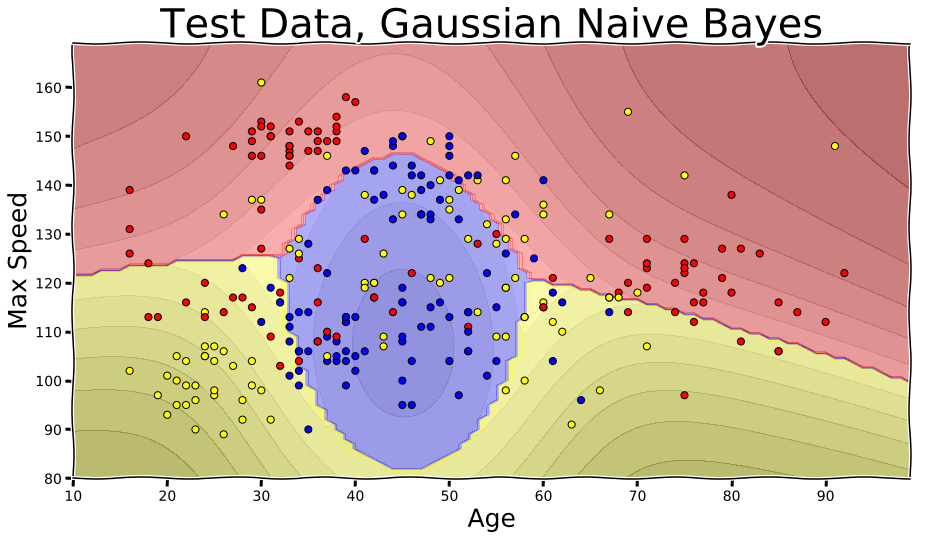

In [26]:
plotPrediction(clf, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, Gaussian Naive Bayes")

In [27]:
clf.score(X_test_2_dim, y_test)

0.57

## Cross Validation

Test Data
* Test data for a real problem is sacred. 
* You should not use it to constantly improve your model, 
* but only as a final check that you did not fool yourself.
* You would want your test data to perform as closely to the training data as possible 

Cross Validation
* Let's you check on some data you have not used for training while not loosing more data for training
* Cross Validation splits the train data in different ways and performs a number of training runs (3 by default). 
* It will train using 2 sets and validate on the third. 
* You will expect your test data to perform closely to the cross validation scores

http://scikit-learn.org/stable/modules/cross_validation.html

In [0]:
clf = GaussianNB()

In [0]:
from sklearn.model_selection import cross_val_score

In [30]:
%%time

# Naive Gaussian Bayes is really fast, we can use a lot of training runs
scores = cross_val_score(clf, X_train_2_dim, y_train, n_jobs=-1, cv=100)

CPU times: user 121 ms, sys: 35.2 ms, total: 156 ms
Wall time: 1.87 s


In [0]:
# scores

In [32]:
# mean score and the 95% confidence interval (2 standard deviations assuming normal distribution)
# https://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.61 (+/- 0.26)


## KNN: Look at the neighbors to make a prediction for a sample yet unknown

https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

In [0]:
from sklearn.neighbors import KNeighborsClassifier
# just looking at the single next neighbor and assume we are the same
clf = KNeighborsClassifier(1)

In [34]:
%%time

clf.fit(X_train_2_dim, y_train)

CPU times: user 2.94 ms, sys: 0 ns, total: 2.94 ms
Wall time: 3.4 ms


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

(<matplotlib.axes._subplots.AxesSubplot at 0x7f6fc3d8ae48>,
 <matplotlib.collections.PathCollection at 0x7f6fc346c240>)

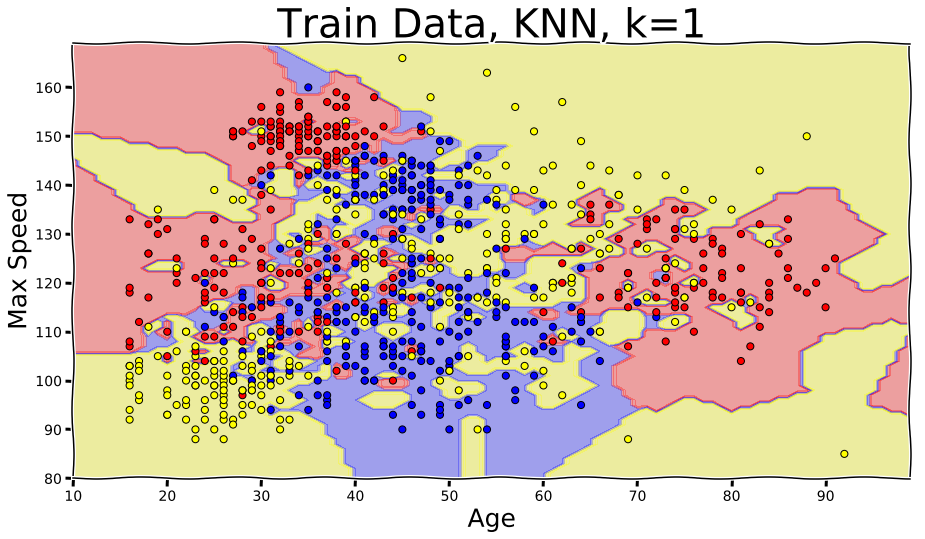

In [35]:
plotPrediction(clf, X_train_2_dim[:, 1], X_train_2_dim[:, 0], 
               'Age', 'Max Speed', y_train,
                title="Train Data, KNN, k=1", n_samples=900)

In [36]:
clf.score(X_train_2_dim, y_train)

0.9358333333333333

(<matplotlib.axes._subplots.AxesSubplot at 0x7f6fc33d96a0>,
 <matplotlib.collections.PathCollection at 0x7f6fc2b7dc88>)

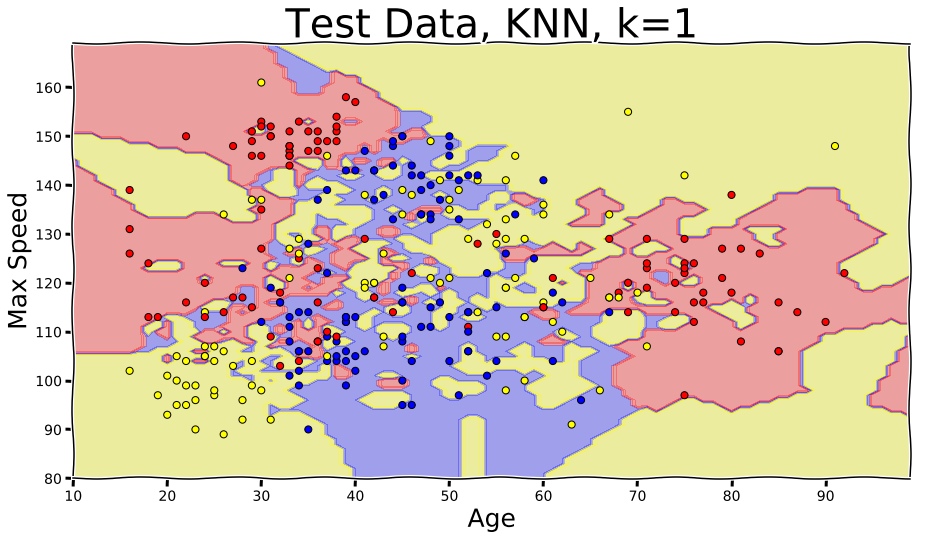

In [37]:
plotPrediction(clf, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, KNN, k=1")

In [38]:
clf.score(X_test_2_dim, y_test)

0.6133333333333333

In [39]:
%%time

scores = cross_val_score(clf, X_train_2_dim, y_train, cv=100, n_jobs=-1)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.62 (+/- 0.28)
CPU times: user 91.8 ms, sys: 4.29 ms, total: 96.1 ms
Wall time: 335 ms


# Exercise: Fight overfitting in KNN

* the number of neighbors (k) is the most important parameter
* Interactive experiment to see the effect of k: https://beta.observablehq.com/@djcordhose/how-to-build-a-teachable-machine-with-tensorflow-js#knndataset
* rule of thumb: smoother decision boundaries imply less overfitting
* execute the notebook up to this point
* change k based on your previous experiments
* what is the important value to check?

In [40]:
k = 1 # set your k here
clf = KNeighborsClassifier(k)
clf.fit(X_train_2_dim, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

## Searching for the best parameters

0.7166666666666667 11


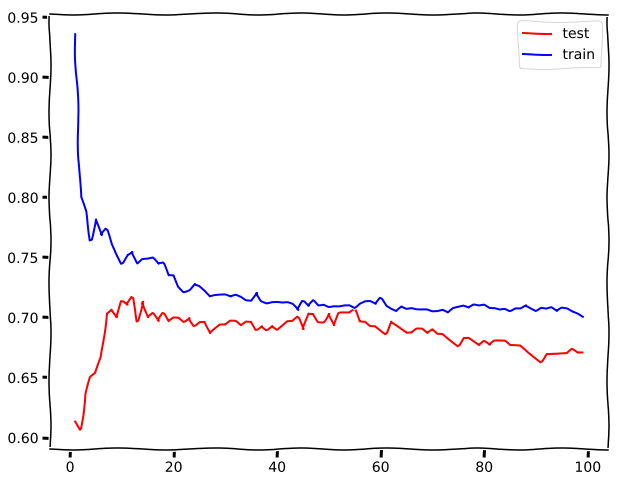

In [56]:
# let's manually implement a loop over one parameter first

# we cheat a little bit since we are using the test set here to tweak the
# parameters, so this is just to illustrate the point

from sklearn.neighbors import KNeighborsClassifier

s_test = []
s_train = []
ks = np.arange(1, 100, dtype=int)
for k in ks:
  clf = KNeighborsClassifier(k)
  clf.fit(X_train_2_dim, y_train)
  s_train.append(clf.score(X_train_2_dim, y_train))
  s_test.append(clf.score(X_test_2_dim, y_test))

s_test = np.array(s_test)
print(s_test.max(), s_test.argmax())

plt.figure(figsize=(10, 8))
plt.plot(ks, s_test, color='red', label='test')
plt.plot(ks, s_train, color='blue', label='train')
plt.legend()

In [54]:
k = 11
clf = KNeighborsClassifier(k)
clf.fit(X_train_2_dim, y_train)

print("Training score: {0:.2f}".format(clf.score(X_train_2_dim, y_train)))
print("Test score: {0:.2f}".format(clf.score(X_test_2_dim, y_test)))

Training score: 0.75
Test score: 0.71


(<matplotlib.axes._subplots.AxesSubplot at 0x7f6fc22fb128>,
 <matplotlib.collections.PathCollection at 0x7f6fc21e35f8>)

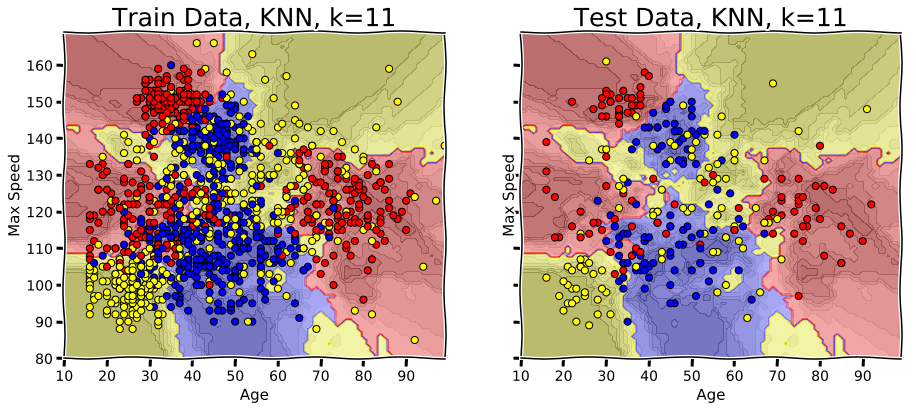

In [55]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(15,6))
la, ra = ax.flatten()

plotPrediction(clf, X_train_2_dim[:, 1], X_train_2_dim[:, 0], 
               'Age', 'Max Speed', y_train,
                title="Train Data, KNN, k={0}".format(k),
                ax = la)

plotPrediction(clf, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, KNN, k={0}".format(k),
                ax = ra)

We can try what is the best number of numbers manually, but grid search does the same thing, only with less manual effort. This one tries the number of neighbors between 1 and 50

In [0]:
%%time 

from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_neighbors': list(range(1, 50)),
    'weights': ['uniform', 'distance'] # are points that are nearer more important?
    }
clf = GridSearchCV(KNeighborsClassifier(), param_grid, n_jobs=-1)
clf.fit(X_train_2_dim, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


CPU times: user 205 ms, sys: 1.43 ms, total: 206 ms
Wall time: 2.72 s


In [0]:
clf.best_params_

{'n_neighbors': 14, 'weights': 'uniform'}

In [0]:
%%time 

clf = KNeighborsClassifier(n_neighbors=14, weights='uniform')
clf.fit(X_train_2_dim, y_train)

CPU times: user 1.14 ms, sys: 1.05 ms, total: 2.19 ms
Wall time: 3.17 ms


(<matplotlib.axes._subplots.AxesSubplot at 0x7f0421fcc320>,
 <matplotlib.collections.PathCollection at 0x7f0421fc5080>)

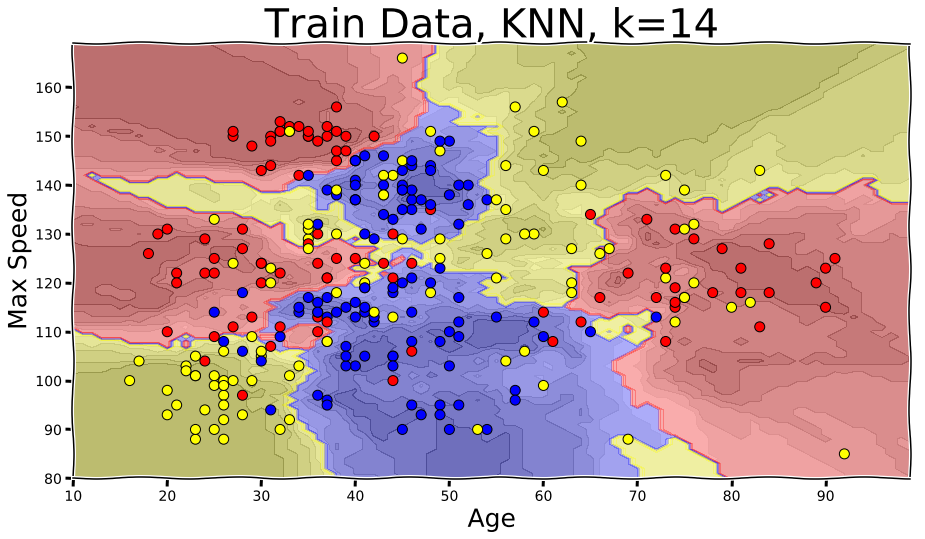

In [0]:
plotPrediction(clf, X_train_2_dim[:, 1], X_train_2_dim[:, 0], 
               'Age', 'Max Speed', y_train,
                title="Train Data, KNN, k=14")

In [0]:
clf.score(X_train_2_dim, y_train)

0.7483333333333333

(<matplotlib.axes._subplots.AxesSubplot at 0x7f0421fd3048>,
 <matplotlib.collections.PathCollection at 0x7f0421ee0908>)

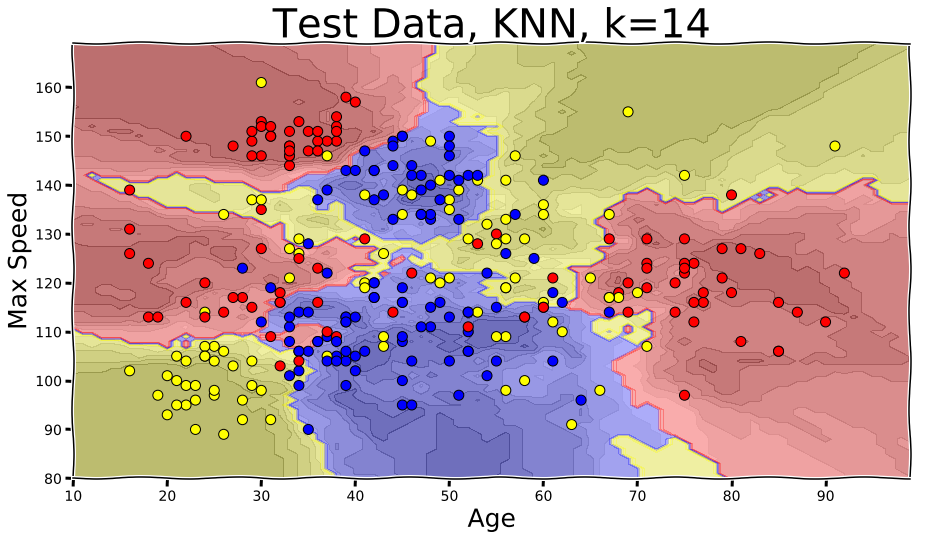

In [0]:
plotPrediction(clf, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, KNN, k=14")

In [0]:
clf.score(X_test_2_dim, y_test)

0.7133333333333334

In [0]:
%%time

scores = cross_val_score(clf, X_train_2_dim, y_train, cv=100, n_jobs=-1)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.71 (+/- 0.26)
CPU times: user 92 ms, sys: 1.29 ms, total: 93.3 ms
Wall time: 255 ms


# From here on choose your favorite topic

* spend an hour working on what you are most interested in
* Work at your one speed
* If you do not have a special interest look at ensemble methods with Random Forst (Sometimes called the Swiss Army Knive for machine learning)
* Ask coaches if you have questions or want to discuss



## Support Vector Machines (SVM)
* SVMs used to be the hot stuff before neural networks stole the show
* SVMs choose a small number of data points to decide where to draw the decision boundary, they are called the *support vectors*
* support vectors are typically close to the decision boundaries

### Linear SVM

In its base version SVMs can only use lines as decision boundaries. Let's see how well this works.

In [0]:
from sklearn.svm import SVC
clf = SVC(kernel='linear', probability=True)
%time clf.fit(X_train_2_dim, y_train)

CPU times: user 3.21 s, sys: 1.74 ms, total: 3.21 s
Wall time: 3.22 s


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [0]:
clf.support_vectors_.shape

(1107, 2)

In [0]:
clf.score(X_train_2_dim, y_train)

0.4666666666666667

(<matplotlib.axes._subplots.AxesSubplot at 0x7f0421ebfdd8>,
 <matplotlib.collections.PathCollection at 0x7f0421e7c940>)

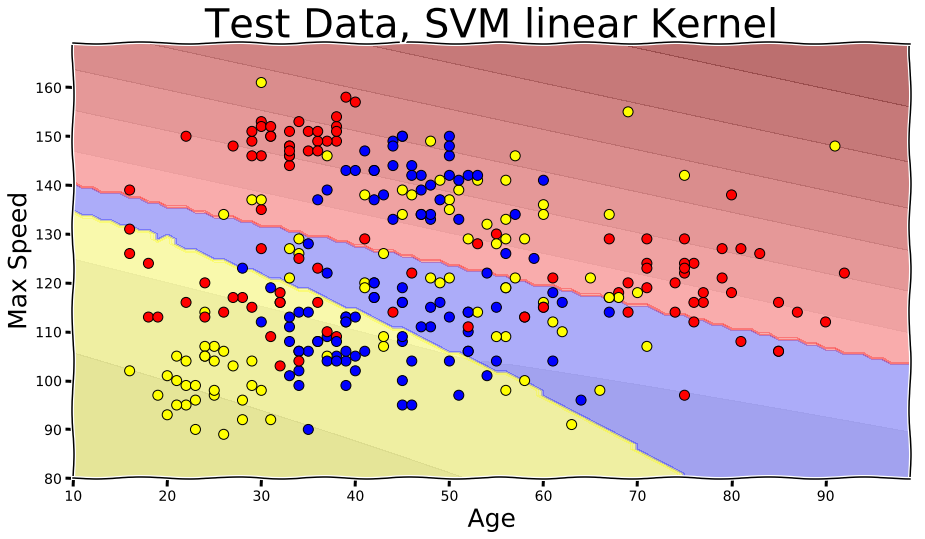

In [0]:
plotPrediction(clf, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, SVM linear Kernel")

In [0]:
clf.score(X_test_2_dim, y_test)

0.43666666666666665

### SVM Kernels

_Kernel Trick allows to solve problems that are not linearly separable_

* As we can see using lines only, we can not even fit the training data, this is called *underfitting*.
* For most realisitic examples we need something better called the 'kernel trick'
* We transform the original problem space into a higher dimension that is separable by lines only
* Radial Base Functions 'rbf' can approximate any function and are trained to perform this transformation (https://en.wikipedia.org/wiki/Radial_basis_function_kernel)

<img src='https://github.com/djcordhose/ml-workshop/blob/master/notebooks/classic/img/svm-kernel-trick.jpg?raw=1'>

Sebastian Thrun for Udacity: https://youtu.be/3Xw6FKYP7e4 


In [0]:
clf = SVC(kernel='rbf', probability=True)
%time clf.fit(X_train_2_dim, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


CPU times: user 476 ms, sys: 595 µs, total: 477 ms
Wall time: 491 ms


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [0]:
clf.support_vectors_.shape

(1097, 2)

In [0]:
clf.score(X_train_2_dim, y_train)

0.8841666666666667

(<matplotlib.axes._subplots.AxesSubplot at 0x7f0421e2b748>,
 <matplotlib.collections.PathCollection at 0x7f0421d28208>)

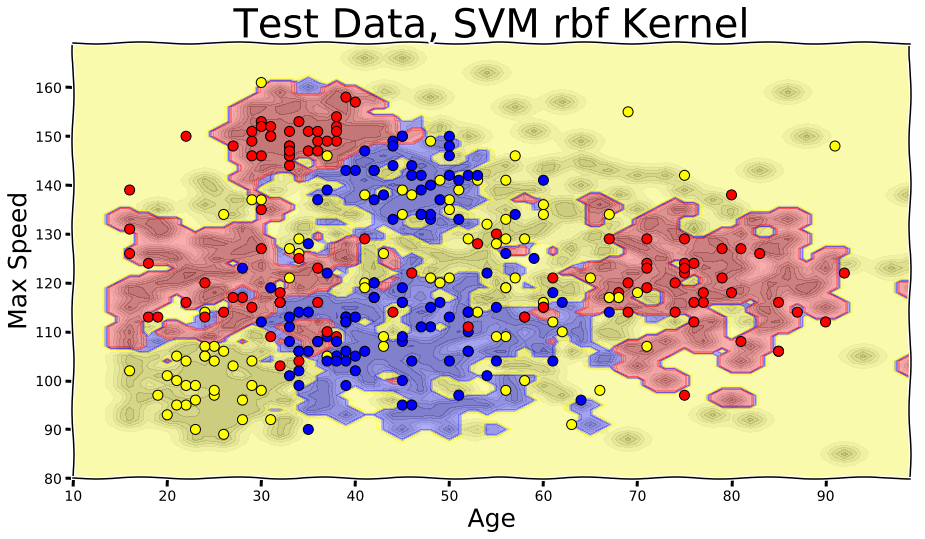

In [0]:
plotPrediction(clf, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, SVM rbf Kernel")

In [0]:
clf.score(X_test_2_dim, y_test)

0.6233333333333333

Again we strongly overfit and need to regularize our model. The two important parameters are
* Gamma
  * reach of a single training sample - low values: far, high values: close
    * https://www.youtube.com/watch?v=m2a2K4lprQw
  * the lower the more points remote from the support vectors influence where the decision boundaries go  
* C (Cost)
  * decides how expensive it is to misclassify one of our support vectors, the smaller the more tolerant to misclassified samples
  * tradeof between smooth decision boundaries and classifying samples correctly
    * https://www.youtube.com/watch?v=joTa_FeMZ2s
    * high cost means rough, complex decision boundaries
    * lower cost means more regularization

Interactively experiment with C and Gamma: https://dash-gallery.plotly.host/dash-svm

http://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html

In [0]:
param_grid = {
    'C': list(np.append(np.arange(0.1, 1.0, 0.1), np.arange(2, 10, 1))),
    'gamma': list(np.append(np.arange(0.001, 0.1, 0.0005), np.arange(.02, 1.0, 0.1))),
}
clf = GridSearchCV(SVC(), param_grid, n_jobs=-1)
%time clf.fit(X_train_2_dim, y_train)
clf.best_params_

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [0]:
clf = SVC(kernel='rbf', probability=True, C=0.3, gamma=0.023)
%time clf.fit(X_train_2_dim, y_train)

In [0]:
clf.score(X_train_2_dim, y_train)

In [0]:
plotPrediction(clf, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, SVM Regularized rbf Kernel")

In [0]:
clf.score(X_test_2_dim, y_test)

# Exercise: Improve Cost and Gamma
* use https://dash-gallery.plotly.host/dash-svm to get a better intuition for C and Gamma
* Change C and Gamma based on your intuition
* Can you do better than the results coming from the grid search?
* If not: Why not?

## Descision Trees

* Split our data set on a certain variable
* Similar to what we have done in the manual classifier, but here the rules are actually learned

In [0]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
%time clf.fit(X_train_2_dim, y_train)

### How is the Decision Tree being Constructed?

We are using the CART algorithm:
* top-down split the set of examples into two new sets
* choose a variable and a value at each step that best splits our customer example
* terminal node when no further gain possible or regularization kicks in

<img src="https://raw.githubusercontent.com/DJCordhose/ai/master/docs/img/dt/cart.png">

http://scikit-learn.org/stable/modules/tree.html#tree-algorithms-id3-c4-5-c5-0-and-cart

### What is the best split?

* choose a feature to split on (either random or best)
* assign a category to each node containing a certain set of samples
* use a metric (Gini or Entropy) to decide how good a node would be based on that category
* sum up weighted metric for both child nodes
* optimize the split for that summed metric

https://machinelearningmastery.com/classification-and-regression-trees-for-machine-learning/

In [0]:
# we perform at most 18 splits of our data until we make a decision where the data point belongs

clf.tree_.max_depth

### Complete Decision Tree

<img src="https://github.com/djcordhose/ml-workshop/blob/master/notebooks/classic/img/dt-all.png?raw=1">

In [0]:
plotPrediction(clf, X_train_2_dim[:, 1], X_train_2_dim[:, 0], 
               'Age', 'Max Speed', y_train,
                title="Train Data, Decision Tree")

In [0]:
clf.score(X_train_2_dim, y_train)

In [0]:
%%time
scores = cross_val_score(clf, X_train_2_dim, y_train, cv=100, n_jobs=-1)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [0]:
plotPrediction(clf, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, Decision Tree")

In [0]:
clf.score(X_test_2_dim, y_test)

We overfit heavily and need to change the relevant parameters of our tree
* its maximum number of splits (depth) - if there is no limit, we can make as many splits as it takes to perfectly match all train data (overfitting)
* how many samples we need at least for a leaf - if it is just one, we could perfectly fit all training data (overfitting)
* how many samples do we need to make another split - not as crucial as the other two, but can still limit overfitting

In [0]:
param_grid = {
    'max_depth': list(range(2, 25)),
    'min_samples_split': list(range(2, 11)),
    'min_samples_leaf': list(range(1, 11))
}
clf = GridSearchCV(DecisionTreeClassifier(), param_grid, n_jobs=-1)
%time clf.fit(X_train_2_dim, y_train)
clf.best_params_

In [0]:
clf = DecisionTreeClassifier(max_depth=6,
                              min_samples_leaf=2,
                              min_samples_split=2)
%time clf.fit(X_train_2_dim, y_train)

In [0]:
clf.tree_.max_depth

In [0]:
clf.score(X_train_2_dim, y_train)

### Reduced Decision Tree

<img src="https://github.com/djcordhose/ml-workshop/blob/master/notebooks/classic/img/dt-lvl3.png?raw=1">

In [0]:
plotPrediction(clf, X_train_2_dim[:, 1], X_train_2_dim[:, 0], 
               'Age', 'Max Speed', y_train,
                title="Train Data, Regularized Decision Tree")

In [0]:
clf.score(X_test_2_dim, y_test)

In [0]:
%%time

scores = cross_val_score(clf, X_train_2_dim, y_train, cv=100, n_jobs=-1)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

## Ensemble Methods on Decision Trees

* Decision Trees in particular have nice properties, but tend to overfit
* We fight overfitting in decision trees with some success
* However, inherent to their nature, decision trees tend to overfit
* Combining more than one classifier is called an "emsemble method"
* Results from individual will be either averaged, majorty, or boosted by others 

### Bagging
* train a number of estimators using only a subset of your data (https://youtu.be/Cn7StaXU_8o)


## Random Forest
* Random Forest is an ensemble technique that trains a number of simple decision trees and uses a majority vote over all of them for prediction
* like Bagging but with additional random selection of features
* Typically uses average of median for regression
* While each decision tree still overfits using many of them softens this problems
* You still need to regularize the underlying decision trees
* sklearn has a default of 10 decision trees for random forest

_Random Forest sometimes is called the swiss army knife of machine learning_

In [0]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_jobs=-1)
%time clf.fit(X_train_2_dim, y_train)

In [0]:
clf.score(X_train_2_dim, y_train)

In [0]:
plotPrediction(clf, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, Random Forest")

In [0]:
clf.score(X_test_2_dim, y_test)

## Random Search

Unfortunately, training random forest classifiers is more expensive than decision trees by the number of estimators it uses (10 in our case). This often  makes using a deterministic grid search over all parameters prohibitively expensive even when you can parallelize over many CPUs. We instead use a randomized search, that tries a number of different combinations and we hope to find the best here.

http://scikit-learn.org/stable/modules/grid_search.html#randomized-parameter-search


In [0]:
# brute force grid search is far too expensive

param_grid = {
    'n_estimators': list(range(3,20)),
    'max_depth': list(range(2, 25)),
    'min_samples_split': list(range(2, 11)),
    'min_samples_leaf': list(range(1, 11))
}
clf = GridSearchCV(RandomForestClassifier(), param_grid, n_jobs=-1)
# %time clf.fit(X_train_2_dim, y_train)
# clf.best_params_

In [0]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {
    'n_estimators': randint(3,20),
    "max_depth": randint(2, 25),
    "min_samples_split": randint(2, 11),
    "min_samples_leaf": randint(1, 11)
}

clf = RandomizedSearchCV(RandomForestClassifier(), param_dist, n_iter=1000, n_jobs=-1)
%time clf.fit(X_train_2_dim, y_train)
clf.best_params_

In [0]:
# parameters found might vary a bit with each run, because it is a random search
clf = RandomForestClassifier(max_depth=8, min_samples_leaf=5, min_samples_split=3, n_estimators=16, n_jobs=-1)
%time clf.fit(X_train_2_dim, y_train)

In [0]:
clf.score(X_train_2_dim, y_train)

In [0]:
plotPrediction(clf, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, Regularized Random Forest")

In [0]:
clf.score(X_test_2_dim, y_test)

In [0]:
%%time

scores = cross_val_score(clf, X_train_2_dim, y_train, cv=100, n_jobs=-1)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# Exercise: Try to optimize on the parameters
* we only have a good guess about the optimal parameters here
* re-run the ramdomized search and try to get better results
* you can also try the grid seach with a limited search range 

## AdaBoost

* begins by fitting a classifier on the original dataset
* by default in Scikit-learn this will be a decision tree, but you are free to choose whatever you want
* draws random samples from the training data 
* then fits additional copies of the classifier on the same dataset
* incorrectly classified samples are more likely to be used in subsequent classifiers 
* as a consequence subsequent classifiers focus more on difficult cases
* classifiers are combined like in other ensemble methods

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html

<br>
<Img src='https://github.com/djcordhose/ml-workshop/blob/master/notebooks/classic/img/boosting.jpg?raw=1' height=300>
  
Taken from this clear and concise explanation video: https://youtu.be/GM3CDQfQ4sw

In [0]:
from sklearn.ensemble import AdaBoostClassifier
# due to its nature can not run in parallel
clf = AdaBoostClassifier()
%time clf.fit(X_train_2_dim, y_train)

In [0]:
clf.score(X_train_2_dim, y_train)

In [0]:
plotPrediction(clf, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, AdaBoost")

In [0]:
clf.score(X_test_2_dim, y_test)

# Advanced Bonus: Neural Networks using TensorFlow 2

In [0]:
# Gives us a well defined version of tensorflow

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

# will also work, but nightly build might contain surprises

# !pip install -q tf-nightly-gpu-2.0-preview

In [0]:
import tensorflow as tf
print(tf.__version__)

In [0]:
# a small sanity check, does tf seem to work ok?
hello = tf.constant('Hello TF!')
print("This works: {}".format(hello))

In [0]:
# this should return True even on Colab
assert tf.test.is_gpu_available()

In [0]:
# we have the gpu version of TensorFlow running
assert tf.test.is_built_with_cuda()

In [0]:
# What kind of GPU are we running on
!nvidia-smi

In [0]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Activation

num_features = 2
num_categories = 3

dropout = 0.6
model = tf.keras.Sequential()

model.add(Input(name='input', shape=(num_features,)))

model.add(Dense(name='hidden1', units=150))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Dense(name='hidden2', units=100))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Dense(name='output', units=num_categories, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
model.summary()

In [0]:
%%time 

BATCH_SIZE=1000
EPOCHS = 2000

history = model.fit(X_train_2_dim, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2, verbose=0)

In [0]:
train_loss, train_accuracy = model.evaluate(X_train_2_dim, y_train, batch_size=BATCH_SIZE, verbose=0)
train_loss, train_accuracy

In [0]:
test_loss, test_accuracy = model.evaluate(X_test_2_dim, y_test, batch_size=BATCH_SIZE, verbose=0)
test_loss, test_accuracy

In [0]:
plt.yscale('log')

plt.ylabel("loss")
plt.xlabel("epochs")

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.legend(["Loss", "Valdation Loss"])

In [0]:
plt.ylabel("accuracy")
plt.xlabel("epochs")

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.legend(["Accuracy", "Valdation Accuracy"])

In [0]:
plotPrediction(model, X_train_2_dim[:, 1], X_train_2_dim[:, 0], 
               'Age', 'Max Speed', y_train,
                title="Train Data, NN")

In [0]:
plotPrediction(model, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, NN")

# Exercise: Neural Network
* scores are a bit lower than random forest: looking at the plot of the decision boundaries could you still find a reason for favoring neural networks over random forests?
* can you improve the results? try training for more epochs or making the layers larger or adding more layers
* can you imagine what the main challenges with neural networks might be?

In [0]:
plotPrediction(model, X[:, 1], X[:, 0], 
               'Age', 'Max Speed', y,
                title="All Data, Neural Networks")